In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
# read offense data
offense = pd.read_csv('data/offense.csv')
# read defense data
defense = pd.read_csv('data/defense.csv')
# read salary data
salary = pd.read_csv('data/salary.csv', index_col=0)
# change columns (uppercase first letter) to match the other data
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
# read standings data
standings = pd.read_csv('data/standings.csv')

Need to fix the offense and defense stats so that they are the previous year. Can do this by adding 1 to the year before merging the datasets. Salary is known at the beginning of the season so the year doesn't have to change.

In [3]:
offense['Year'] += 1
defense['Year'] += 1

In [4]:
# merge the offense and defense data with suffixes
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
# merge the salary data
combined = pd.merge(combined, salary, on=['Team', 'Year'])
# merge the standings dataframe - use left so 2018 data stays
combined = pd.merge(combined, standings, on=['Team', 'Year'], how='left')

In [5]:
# split out the X and y from combined
X_all = combined[combined.columns[:-8]].copy()
y_all = combined[combined.columns[-8:]].copy()

# add team and year back into y
y_all.insert(0, 'Team', X_all['Team'])
y_all.insert(1, 'Year', X_all['Year'])

# add win percentage column
y_all['W_Pct'] = y_all['W'] / 16

In [6]:
# scale X
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X_all[X_all.columns[2:]]),
                        index=X_all.index, columns=X_all.columns[2:])

X_scaled.insert(0, 'Team', X_all['Team'])
X_scaled.insert(1, 'Year', X_all['Year'])

In [7]:
# break out the 2018 data first (X_future)
X_future = X_scaled[X_scaled['Year'] == 2018]
y_future = y_all[y_all['Year'] == 2018]

# get the validation set (2017)
X_valid = X_scaled[X_scaled['Year'] == 2017].drop(['Team', 'Year'], axis=1)
y_valid = y_all[y_all['Year'] == 2017].drop(['Team', 'Year'], axis=1)

# remove the 2017 and 2018 data from X and y
X = X_scaled[X_scaled['Year'] < 2017]
y = y_all[y_all['Year'] < 2017]

# keep team and year just in case
team_year = X_scaled[['Team', 'Year']]

# drop the team and year columns for X and y
X = X.drop(['Team', 'Year'], axis=1)
y = y.drop(['Team', 'Year'], axis=1)

# Baseline Models

Predicting win percentage (W_Pct)

In [8]:
# split into train and test set

target_var = 'DIFF'

def get_train_test():
    return train_test_split(X, y[target_var],
                            test_size=0.3, random_state=42)

R2 Score: -0.08247477348577781
RMSE: 101.54631796488496


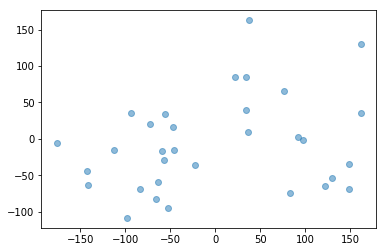

In [9]:
lr = LinearRegression()

lr.fit(X, y[target_var])

y_pred = lr.predict(X_valid)

print('R2 Score: {}'.format(r2_score(y_valid[target_var], y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_valid[target_var], y_pred))))

_ = plt.scatter(y_valid[target_var], y_pred, alpha=0.5)

## Forward Subset Selection with Leave One Out Cross Validation

In [14]:
fs_models = {}

unused_vars = X.columns
model_vars = []

lr = LinearRegression()

loo = LeaveOneOut()

mse = []

max_features = 20

for i in range(1, max_features + 1):
    print(f'{i}, ', end='')
    best_mse = 1e100
    for var in unused_vars:
        loo_mse = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index][target_var], y.iloc[test_index][target_var]
            lr.fit(X_train[model_vars + [var]], y_train)
            y_pred = lr.predict(X_test[model_vars + [var]])
            loo_mse.append((y_test.values - y_pred) ** 2)
        if np.mean(loo_mse) < best_mse:
            best_mse = np.mean(loo_mse)
            best_var = var
    mse.append(best_mse)
    model_vars.append(best_var)
    unused_vars = unused_vars.drop(best_var)
    fs_models[i] = [best_mse, model_vars.copy()]

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 

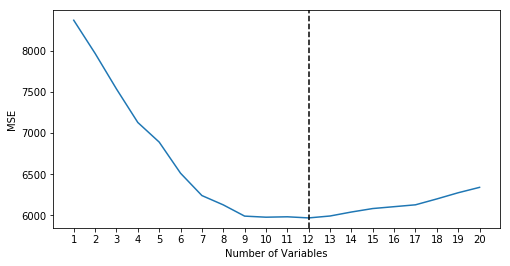

In [18]:
min_pt = min(fs_models, key=fs_models.get)
best_vars = fs_models[min_pt][1]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

_ = ax1.plot(range(1, max_features+1), mse)
_ = ax1.axvline(min_pt, c='k', linestyle='dashed')
_ = ax1.set(xlabel='Number of Variables', ylabel='MSE')
_ = ax1.set_xticks(range(1, 21))

Training R2: 0.46638181203292456
Validation R2: 0.025674778647730045


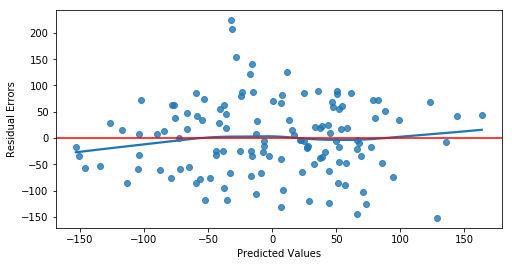

In [19]:
lr.fit(X[best_vars], y[target_var])
print('Training R2: {}'.format(lr.score(X[best_vars], y[target_var])))
print('Validation R2: {}'.format(lr.score(X_valid[best_vars], y_valid[target_var])))
y_pred = lr.predict(X[best_vars])
residuals = y[target_var] - y_pred

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = sns.regplot(y_pred, residuals, lowess=True, ax=ax)
_ = ax.axhline(0, c='r')
_ = ax.set(xlabel='Predicted Values', ylabel='Residual Errors')

lr_pred = lr.predict(X_valid[best_vars])

## Lasso with Leave One Out Cross Validation

In [22]:
from sklearn.model_selection import LeaveOneOut

if target_var == 'W_Pct':
    alphas = np.linspace(.001, .1, 100)
elif target_var == 'DIFF':
    alphas = np.linspace(0.1, 100, 100)

lasso = Lasso()

loo = LeaveOneOut()

mse = []
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    loo_mse = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index][target_var], y.iloc[test_index][target_var]
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        loo_mse.append((y_test.values - y_pred) ** 2)
    lasso.fit(X, y[target_var])
    coefs.append(lasso.coef_)
    mse.append(np.mean(loo_mse))
coefs = np.array(coefs)
mse = np.array(mse)

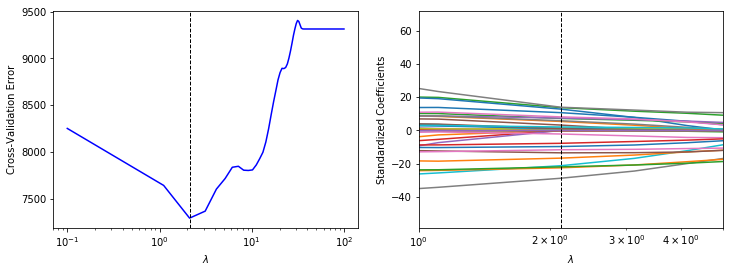

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.semilogx(alphas, mse, color='blue')
min_ind = mse.argmin()
ax1_ylim = ax1.get_ylim()
ax1.axvline(alphas[min_ind], linestyle='dashed', color='k', linewidth=1)
ax1.set(ylim=ax1_ylim, xlabel=r'$\lambda$', ylabel='Cross-Validation Error')

for i in range(len(X.columns)):
    ax2.semilogx(alphas, coefs[:, i], label=X.columns[i])
    
ax2.axvline(alphas[min_ind], linestyle='dashed', color='k', linewidth=1)
if target_var == 'W_Pct':
    xlim = (.001, .01)
elif target_var == 'DIFF':
    xlim = (1, 5)
_ = ax2.set(xlim=xlim, xlabel=r'$\lambda$', ylabel='Standardized Coefficients')

Training R2: 0.48646785607433923
validation R2: 0.10529370593199239


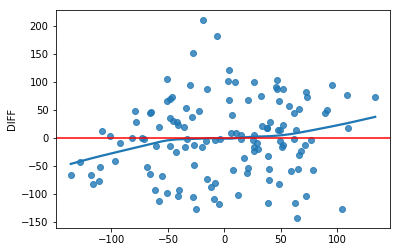

In [24]:
lasso.set_params(alpha=alphas[min_ind])
lasso.fit(X, y[target_var])
print('Training R2: {}'.format(lasso.score(X, y[target_var])))
print('validation R2: {}'.format(lasso.score(X_valid, y_valid[target_var])))
y_pred = lasso.predict(X)

residuals = y[target_var] - y_pred

sns.regplot(y_pred, residuals, lowess=True)
plt.axhline(0, c='r')

lasso_pred = lasso.predict(X_valid)

## Random Forest Regression with Grid Search

In [25]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

param_grid = {
    'max_depth': range(1, 10),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 5)
}

gs = GridSearchCV(rf, param_grid, n_jobs=-1, cv=10)
gs.fit(X, y[target_var])

print(gs.best_score_, gs.best_params_)

0.09091532973588215 {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}


Training R2: 0.8636200606601709
Validation R2: 0.11315462522558241


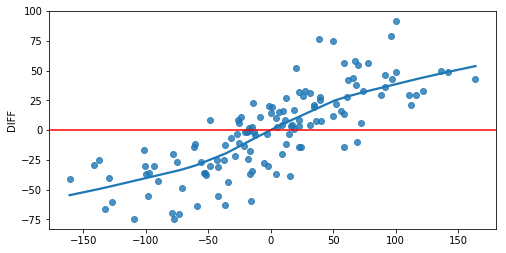

In [26]:
rf = gs.best_estimator_

print('Training R2: {}'.format(rf.score(X, y[target_var])))
print('Validation R2: {}'.format(rf.score(X_valid, y_valid[target_var])))

y_pred = rf.predict(X)

residuals = y[target_var] - y_pred

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = sns.regplot(y_pred, residuals, lowess=True, ax=ax)
_ = ax.axhline(0, c='r')

rf_pred = rf.predict(X_valid)

## Blending Models

In [27]:
preds = pd.DataFrame([lr_pred, lasso_pred, rf_pred]).T
preds.columns = ['lr', 'lasso', 'rf']

#### Average of Predictions

In [28]:
for col in preds.columns:
    print('{:^7} Validation R2: {:.4f}'.format(col, r2_score(y_valid[target_var], preds[col])))
print('Blended Validation R2: {:.4f}\n'.format(r2_score(y_valid[target_var], preds.mean(axis=1))))

for col in preds.columns:
    print('{:^7} Validation MSE: {:.4f}'.format(col, mean_squared_error(y_valid[target_var], preds[col])))
print('Blended Validation MSE: {:.4f}'.format(mean_squared_error(y_valid[target_var], preds.mean(axis=1))))

  lr    Validation R2: 0.0257
 lasso  Validation R2: 0.1053
  rf    Validation R2: 0.1132
Blended Validation R2: 0.1312

  lr    Validation MSE: 9281.4221
 lasso  Validation MSE: 8522.9722
  rf    Validation MSE: 8448.0890
Blended Validation MSE: 8276.4844


#### Linear Regression of Predictions

In [29]:
lr = LinearRegression()

lr.fit(preds, y_valid[target_var])

y_pred = lr.predict(preds)

print('Linear Regression Model Blend R2: {}'.format(r2_score(y_valid[target_var], y_pred)))
print('Linear Regression Model Blend MSE: {}'.format(mean_squared_error(y_valid[target_var], y_pred)))

Linear Regression Model Blend R2: 0.1517243270323132
Linear Regression Model Blend MSE: 8080.674060690184


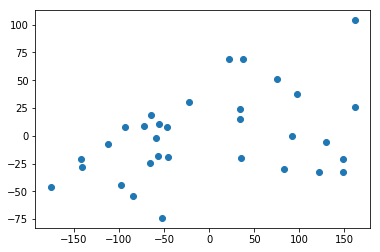

In [30]:
plt.scatter(y_valid[target_var], y_pred)

In [32]:
list(zip(team_year[team_year['Year'] == 2017]['Team'], 
         team_year[team_year['Year'] == 2017]['Year'],
         y_valid[target_var], np.round(y_pred)))

[('BUF', 2017, -57.0, -18.0),
 ('DAL', 2017, 22.0, 69.0),
 ('TEN', 2017, -22.0, 30.0),
 ('SF', 2017, -52.0, -74.0),
 ('ATL', 2017, 38.0, 69.0),
 ('OAK', 2017, -72.0, 9.0),
 ('NE', 2017, 162.0, 104.0),
 ('HOU', 2017, -98.0, -45.0),
 ('MIA', 2017, -112.0, -8.0),
 ('CAR', 2017, 36.0, -20.0),
 ('PHI', 2017, 162.0, 26.0),
 ('NYJ', 2017, -84.0, -54.0),
 ('CIN', 2017, -59.0, -2.0),
 ('PIT', 2017, 98.0, 38.0),
 ('KC', 2017, 76.0, 51.0),
 ('NO', 2017, 122.0, -33.0),
 ('CHI', 2017, -56.0, 11.0),
 ('ARI', 2017, -66.0, -24.0),
 ('CLE', 2017, -176.0, -46.0),
 ('GB', 2017, -64.0, 19.0),
 ('WAS', 2017, -46.0, -19.0),
 ('JAC', 2017, 149.0, -33.0),
 ('IND', 2017, -141.0, -28.0),
 ('TB', 2017, -47.0, 8.0),
 ('SEA', 2017, 34.0, 15.0),
 ('LAC', 2017, 83.0, -30.0),
 ('DEN', 2017, -93.0, 8.0),
 ('BAL', 2017, 92.0, 0.0),
 ('NYG', 2017, -142.0, -21.0),
 ('DET', 2017, 34.0, 24.0),
 ('LA', 2017, 149.0, -21.0),
 ('MIN', 2017, 130.0, -5.0)]